**Actividad presentada por:**
- Pedro Durán Porras
- Andoni Alonso Gandariasbeiteia
- Marta Izquierdo Franco
- Noelia Seco Redondo
- Sergio Naranjo Fernández

# ACTIVIDAD 3 (GRUPAL): REDES NEURONALES RECURRENTES (RNN)

---

En esta actividad grupal, vamos a utilizar las RNN para identificar la intensidad de odio en mensajes escritos en las redes sociales. Esta actividad forma parte del proyecto transversal del Máster, ¡así que seguro que ya estás familiarizado/a con el dataset!

Por sencillez, se adjunta un documento csv que es una versión resumida del dataset original del proyecto transversal. En este dataset, solo se incluyen los mensajes que han sido catalogados como contenedores de odio. También se han eliminado las features innecesarias para este trabajo simplemente para hacer todo el proceso más rápido computacionalmente hablando.

El dataset a utilizar consiste en 12280 mensajes de odio. Los mensajes pueden pertenecer a cinco categorias (numeradadas del 1 al 5), siendo 1 la menor intensidadd y 5 la mayor intensidad de odio del mensaje. El dataset ya ha sido procesado para eliminar ciertos caracteres que podrían darte problemas y para utilizar una codificación más amigable.

Empezamos, como siempre, incluyendo todo lo que vamos a necesitar. Según lo que vayas a hacer, es posible que necesites incluir alguna librería extra.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Nuevas librerías
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cargamos el dataset. Lo encontrarás adjunto a este Notebook, al descargar la actividad del Campus Virtual.

In [2]:
# Leemos el fichero
data = pd.read_csv('dataset.csv', sep=";", encoding='utf-8')
# Mostramos las 5 primeras filas
data.head()

,CONTENIDO A ANALIZAR,INTENSIDAD
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso. el supremo se ded...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,"preguntárselo al fracasado, media carrera en 6...",4


Cambiamos el nombre de las features para hacer su manejo más amigable:

In [3]:
data = data.rename(columns={'CONTENIDO A ANALIZAR': 'mensaje', 'INTENSIDAD': 'intensidad'})
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso. el supremo se ded...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,"preguntárselo al fracasado, media carrera en 6...",4


Mostramos información básica para saber a qué nos enfrentamos:

In [4]:
data.shape

(12279, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12279 entries, 0 to 12278
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   mensaje     12279 non-null  object
 1   intensidad  12279 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 192.0+ KB


Mostramos ahora la distribución de mensajes de acuerdo a su intensidad. Verás rápidamente que estamos en problemas: hay un gran desbalanceo.

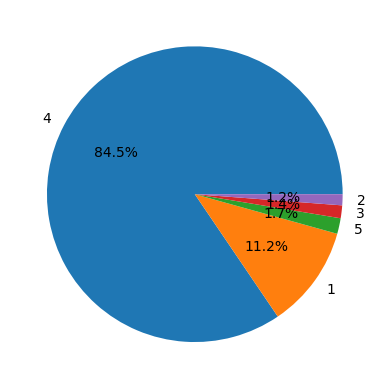

In [6]:
plt.pie(data['intensidad'].value_counts().values,
        labels = data['intensidad'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

Para hacer todo más sencillo y evitar asociaciones indeseadas, vamos a trabajar solo con minúsculas. Además, quitamos los signos de puntuación de los mensajes

In [7]:
# Convertimos a minúsculas
data['mensaje'] = data['mensaje'].map(lambda x: x.lower())

# Función para eliminar signos de puntuación
def eliminar_signos(texto):
    return re.sub(f"[{re.escape(string.punctuation)}]", "", texto)

# Aplicamos la función al dataset
data['mensaje'] = data['mensaje'].map(eliminar_signos)
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso el supremo se dedi...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,preguntárselo al fracasado media carrera en 6 ...,4


Eliminamos las "stopwords" o palabras vacías. Las stopwords son palabras comunes que, en general, no contienen información relevante para el análisis de texto y suelen ser filtradas antes de procesar los datos. Ejemplos típicos de stopwords en español son: "el", "la", "los", "las", "un", "una", "de", "y", "o", etc.

In [8]:
# Obtenemos las stopwords en español
stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()

# Definimos una función para eliminar stopwords y lematizar
def filtrar_palabras(texto):
    palabras_filtradas = []
    for palabra in texto.split():
        if palabra not in stop_words:
            palabra_lema = lemmatizer.lemmatize(palabra)
            palabras_filtradas.append(palabra_lema)
    return ' '.join(palabras_filtradas)

# Aplicamos la función
data['mensaje'] = data['mensaje'].apply(filtrar_palabras)
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido presiden...,3
1,habrí­a reabrir caso supremo dedica proteger s...,3
2,parece exagerado pedir tres años prisión cifue...,3
3,parece delincuentes niegan evidencias pruebas ...,3
4,preguntárselo fracasado medium carrera 6 meses...,4


Creamos los conjuntos de entrenamiento y de test:

In [9]:
X = data['mensaje']
y = data['intensidad']

# Dividimos el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertimos a numpy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Creamos datasets de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Mostramos un mensaje y su intensidad, simplemente para ver que todo va bien:

In [10]:
for men, inte in train_dataset.take(1):
  print('mensaje: ', men.numpy())
  print('nivel de odio: ', inte.numpy())

mensaje:  b'tarado abascal dice gran lider tarado trump'
nivel de odio:  4


Mezclamos los datos de forma aleatoria:

In [11]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [12]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
for men, inte in train_dataset.take(1):
  print('mensaje: ', men.numpy()[:3])
  print()
  print('nivel de odio: ', inte.numpy()[:3])

mensaje:  [b'saliros islas canarias putos colonizadores mierda canarias \xc3\xa1frica'
 b'facista dem\xc3\xb3crata willy' b'arrogante comentario denota envidia']

nivel de odio:  [4 1 4]


Definimos y configuramos un codificador de texto utilizando la capa TextVectorization

In [14]:
# Empezamos definiendo el tamaño del vocabulario
tamaño_vocabulario = 1000

# Creamos una capa de vectorización de texto
vectorizador = tf.keras.layers.TextVectorization(
    max_tokens=tamaño_vocabulario
)

# Se extraen solo los textos del conjunto de datos de entrenamiento
def extraer_texto(texto, etiqueta):
    return texto

# Adaptamos el vectorizador al texto del conjunto de datos de entrenamiento
dataset_texto = train_dataset.map(extraer_texto)
vectorizador.adapt(dataset_texto)

In [15]:
# Obtenemos el vocabulario aprendido por la capa de vectorización
vocabulario = np.array(vectorizador.get_vocabulary())

# Mostramos las primeras 20 palabras del vocabulario
primeras_20_palabras = vocabulario[:20]
primeras_20_palabras

array(['', '[UNK]', 'si', 'mierda', 'puta', 'ser', 'asco', 'gobierno',
       'panfleto', 'q', 'españa', 'paí\xads', 'gente', 'vergüenza',
       'gentuza', 'vaya', 'basura', 'va', 'gilipollas', 'solo'],
      dtype='<U25')

# Ejercicio

Construye una RNN que pueda detectar el nivel de odio de un mensaje.

**Tenéis plena liberta para realizar la red y para hacer cualquier modificación a los datos.**

## 1. Introducción

En esta actividad se propone abordar el problema de detección de la intensidad del odio como un caso de clasificación de texto multiclase, para lo cual resulta fundamental emplear Redes Neuronales Recurrentes (RNN) y, en particular, sus variantes avanzadas como las LSTM bidireccionales. Dado que estas arquitecturas permiten modelar el contexto y el orden secuencial de las palabras en un mensaje, aspectos esenciales para comprender su significado e intención, se optará por una LSTM bidireccional que, a través de su capacidad para procesar el texto tanto de forma ascendente como descendente, enriquece la representación contextual. 

El principal desafío del conjunto de datos consiste en el gran desbalance de clases (con la clase mayoritaria representando el 84,5 % de los ejemplos), por lo que se emplearán pesos de clase (`class_weight`) durante el entrenamiento para penalizar adecuadamente los errores en las categorías minoritarias y forzar al modelo a prestarles atención. Finalmente, a parte de la precisión (`accuracy`), se evaluará el desempeño mediante un informe de clasificación (precisión, recall y f1-score por clase) y la matriz de confusión, garantizando así una visión completa de la eficacia de la red, junto a gráficas comparativas.

## 2. Preparación adicional de los datos

### 2.1. Ajuste de etiquetas

La librería Keras espera que las etiquetas de clasificación comiencen en 0. Sin embargo, disponemos etiquetas dentro de un rango de 1 a 5, por lo que será necesario convertirlas a un rango de 0 a 4.

In [16]:
# Restar 1 a todas las etiquetas
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Verificar los valores únicos para confirmar el cambio
print(f"Etiquetas originales: {np.unique(y_train)}")
print(f"Etiquetas ajustadas: {np.unique(y_train_adjusted)}")

Etiquetas originales: [1 2 3 4 5]
Etiquetas ajustadas: [0 1 2 3 4]


In [17]:
# Repetir división y mezcla con este cambio

# División en entrenamiento y prueba
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_adjusted))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_adjusted))

# Mezclar y agrupar en lotes
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Adaptar vectorizador
vectorizador = tf.keras.layers.TextVectorization(max_tokens=tamaño_vocabulario)
dataset_texto = train_dataset.map(extraer_texto)
vectorizador.adapt(dataset_texto)
vocabulario = np.array(vectorizador.get_vocabulary())

### 2.2. Calcular pesos de clase

Se considera necesario calcular los pesos de cada clase para contrarrestar el desbalanceo encontrado en el conjunto de datos.

In [18]:
# Calcular los pesos de clase con etiquetas ajustadas
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_adjusted),
    y=y_train_adjusted
)

# Convertir a dict con mapeo del índice de la clase a su peso
class_weight_dict = dict(enumerate(class_weights))

print("\nPesos calculados para cada clase:")
for clase, peso in class_weight_dict.items():
    print(f" - Clase {clase + 1}: Peso {peso:.2f}")


Pesos calculados para cada clase:
 - Clase 1: Peso 1.79
 - Clase 2: Peso 15.97
 - Clase 3: Peso 14.03
 - Clase 4: Peso 0.24
 - Clase 5: Peso 11.62


## 3. Construcción y entrenamiento del modelo

### 3.1. Diseño de arquitectura del modelo

A continuación se define la arquitectura del modelo de la siguiente manera: en primer lugar, se utiliza la capa de vectorización previamente adaptada para convertir el texto en secuencias de índices. Posteriormente, se aplica una capa de embedding que transformará estos índices en vectores densos, capaces de capturar relaciones semánticas y cuya representación se optimizará durante el entrenamiento. El núcleo de la red estará formado por dos capas LSTM bidireccionales, que procesan el texto en ambas direcciones para enriquecer el contexto. La primera generá una secuencia de estados ocultos que contienen información contextualizada y la segunda procesa esta secuencia enriquecida para aprender relaciones de más alto nivel.

Para evitar el sobreajuste, se intercalan capas de dropout tras cada capa LSTM que desactivarán aleatoriamente un porcentaje de neuronas en cada paso de entrenamiento. Finalmente, se incorpora una capa densa de salida con cinco neuronas (una por categoría de intensidad de odio) y activación softmax, de modo que el modelo entregue como resultado una distribución de probabilidad sobre las cinco clases.

In [138]:
# Hiperparámetros
embedding_dim = 128  # Dimensión de los vectores de palabras
lstm_units_1 = 32   # Unidades en la primera capa LSTM
lstm_units_2 = 16    # Unidades en la segunda capa LSTM
dropout_rate = 0.6   # Tasa de dropout para regularización
num_classes = len(np.unique(y_train_adjusted))

# Construcción del modelo secuencial
modelo_lstm = tf.keras.Sequential([
    # 1. Capa de vectorización
    vectorizador,
    
    # 2. Capa de Embedding
    layers.Embedding(
        input_dim=tamaño_vocabulario,
        output_dim=embedding_dim,
        name="embedding"
    ),
    
    # 3. Primera capa LSTM bidireccional: generar secuencia con info contextualizada
    layers.Bidirectional(
        layers.LSTM(lstm_units_1, return_sequences=True), 
        name="bidirectional_lstm_1"
    ),
    layers.Dropout(dropout_rate), # Dropout para regularizar

    # 4. Segunda capa LSTM bidireccional: vector para relaciones de más alto nivel
    layers.Bidirectional(
        layers.LSTM(lstm_units_2), 
        name="bidirectional_lstm_2"
    ),
    layers.Dropout(dropout_rate), # Dropout para regularizar

    # 5. Capa de salida
    layers.Dense(num_classes, activation='softmax', name="output")
])

### 3.2. Estructura del modelo

En esta sección, se visualiza la arquitectura del modelo. El número de parámetros a entrenar no se pueden observar aún ya que, al tener una entrada flexible de cadenas de texto, Keras devuelve una construcción diferida. Por lo tanto, las matrices de pesos se crean tras la compilación y el entrenamiento.

In [139]:
modelo_lstm.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 3.3. Compilación del modelo

Seguidamente, se configura el proceso de aprendizaje. Se emplea la función de pérdida `SparseCategoricalCrossentropy`, ya que las etiquetas están en formato entero de 0 a 4. Como optimizador, se utiliza `Adam`, reconocido por su robustez y eficiencia en tareas de NLP. Por último, se incluye la métrica `accuracy` como referencia para observar de manera rápida la evolución del entrenamiento, porque permite observar el porcentaje de predicciones correctas durante el entrenamiento y validación.

In [140]:
# Compilar el modelo
modelo_lstm.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy']
)

### 3.4. Entrenamiento del modelo

Para terminar el modelo, se entrena utilizando los datos de entrenamiento y validando con los de prueba (```test_dataset```). Es importante mencionar que se incluyen los pesos de las clases (```class_weight_dict```) calculados previamente, para compensar los desequilibrios entre las clases. Para evitar entrenar de más y caer en overfitting, se incluye un EarlyStopping, que detiene el entrenamiento si la pérdida en el conjunto de validación (```val_loss```) no mejora tras 7 épocas. En ese momento, restaura  los pesos del modelo correspondientes a la mejor época, la 7º anterior a finalizar de entrenar.

In [141]:
# Callback de Early Stopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=7,
    verbose=1,
    restore_best_weights=True
)

In [142]:
# Número de épocas para el entrenamiento
#epochs = 50

# Entrenar el modelo
history = modelo_lstm.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    class_weight=class_weight_dict,
    callbacks=[early_stopping_callback]
)


Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 28s 152ms/step - accuracy: 0.3787 - loss: 1.5761 - val_accuracy: 0.6417 - val_loss: 1.3359
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.5149 - loss: 1.5538 - val_accuracy: 0.5782 - val_loss: 1.2266
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 25s 161ms/step - accuracy: 0.6116 - loss: 1.3800 - val_accuracy: 0.5843 - val_loss: 1.0939
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step - accuracy: 0.5974 - loss: 1.2369 - val_accuracy: 0.5692 - val_loss: 1.0525
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step - accuracy: 0.6338 - loss: 1.0983 - val_accuracy: 0.5240 - val_loss: 1.1877
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.6359 - loss: 0.9536 - val_accuracy: 0.5835 - val_loss: 0.9989
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - accuracy: 0.6206 - loss: 0.9348 - val_accuracy: 0.6046 - val_loss: 1.0146
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - accuracy: 0.6730 - loss: 0

In [143]:
# Estructura con parámetros del modelo
modelo_lstm.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 128)      │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, None, 64)       │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 32)             │        10,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 539,249 (2.06 MB)

 Trainable params: 179,749 (702.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 359,500 (1.37 MB)

## 4. Evaluación del modelo

Una vez completado el entrenamiento, se evalua su rendimiento de forma visual y numérica. Esto permitirá ver si el modelo está aprendiendo y si hay algún posible sobreajuste.

### 4.1. Predicción

Se utiliza el dataset de prueba ```test_dataset``` para hacer las predicciones.

In [144]:
# Realizar predicciones sobre el conjunto de prueba
y_pred_probs = modelo_lstm.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Necesitamos obtener las etiquetas verdaderas del dataset de prueba
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

# Nombres de las clases
class_names = ['Intensidad 1', 'Intensidad 2', 'Intensidad 3', 'Intensidad 4', 'Intensidad 5']

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step  


Se genera un informe de clasifiación con las siguiente métricas:
- Precision: proporción de predicciones correctas sobre el total de predicciones realizadas a dicha etiqueta, es decir, (verdaderos positivos)/(verdaderos positivos + falsos positivos).
- Recall (sensibilidad): proporción de verdaderos positivos detectados, es decir, (verdaderos positivos)/(verdaderos positivos + falsos negativos).
- F1-score: media armónica entre precisión y recall.
- Support: cantidad de ejemplos de cada clase

In [145]:
# 1. Informe de clasificación
print("--- Informe de Clasificación ---")
print(classification_report(y_true, y_pred, target_names=class_names))

--- Informe de Clasificación ---
              precision    recall  f1-score   support

Intensidad 1       0.31      0.53      0.39       277
Intensidad 2       0.07      0.28      0.11        25
Intensidad 3       0.03      0.16      0.05        32
Intensidad 4       0.94      0.70      0.80      2081
Intensidad 5       0.09      0.32      0.14        41

    accuracy                           0.66      2456
   macro avg       0.29      0.40      0.30      2456
weighted avg       0.83      0.66      0.73      2456



Revisando el informe de clasificación se observa:
- Intensidad 1: tiene un recall de 0.53, es decir, el modelo reconoce más de la mitad de los casos reales. Sin embargo, su precisión es baja, 0.31, por lo que se equivoca bastante al predecir esta clase, creando falsas alarmas.
- Intensidad 2 y 3: tienen métricas muy bajas, tanto precisión, como recall, como f1-score, lo cual se explica por su bajo support (hay muy pocos ejemplos de estas clases), por ello el modelo no está aprendiendo bien estas clases.
- Intensidad 4: viendo su support y comparándolo con el support del resto de clases, es la mejor representada, con 2081 casos, por esto el modelo la detecta con mayor precisión (0.94) y tiene f1-score de 0.80, lo que es muy bueno.
- Intensidad 5: tiene muy pocas muestras, 41 y por ello métricas bajas, aunque con un recall algo más aceptable, 0.32, que las clases de intensidad 2 y 3.


--- Matriz de Confusión ---


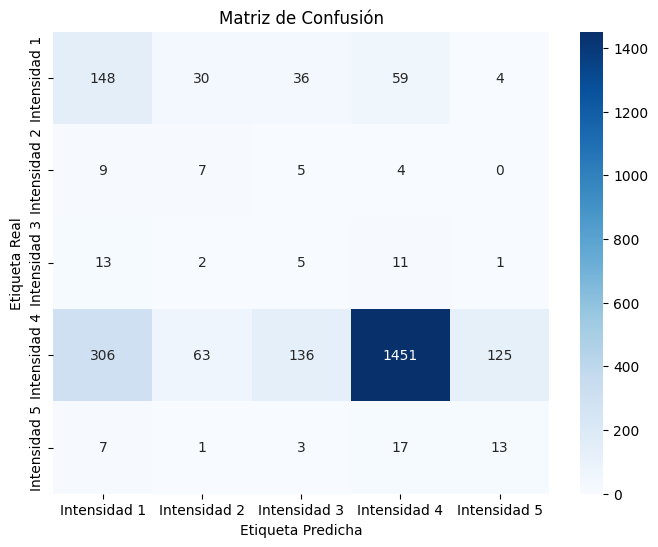

In [146]:
# 2. Matriz de confusión
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

La matriz de confusión muestra cómo el modelo clasifica cada una de las clases, comparando las clases reales (filas) con las predichas (columnas). Permite visualizar los aciertos y los errores cometidos por clase. Visualizándola, se pueden extraer las siguientes conclusiones:

- La clase mejor clasificada es Intensidad 4, por lo que el modelo es muy bueno identificando esta clase. Aunque esto es porque es la más representada con una gran diferencia respecto al resto.
  
- En la clase Intensidad 1, se clasificaron correctamente 148 muestras, aunque hubo 59 mal clasificados como Intensidad 4 (porque Intensidad 4 es la más representada), también hubo varios mal clasificados como otras clases. Las clases Intensidad 2, 3 y 5 tienen muy bajo rendimiento, con la mayoría de sus casos siendo confundidos como Intensidad 4 debido al desbalance del conjunto de datos. Además, es curioso que en cada una de ellas la clase con más casos predichos nunca es la propia.

Como conclusión, el modelo tiende a predecir la clase Intensidad 4 incluso cuando no corresponde, por el desbalanceo, lo que causa un sesgo hacia dicha clase. Por ello, el modelo aprende bien la clase dominante, pero no logra generalizar correctamente hacia las clases con menos ejemplos.

### 4.2. Comparativa gráfica

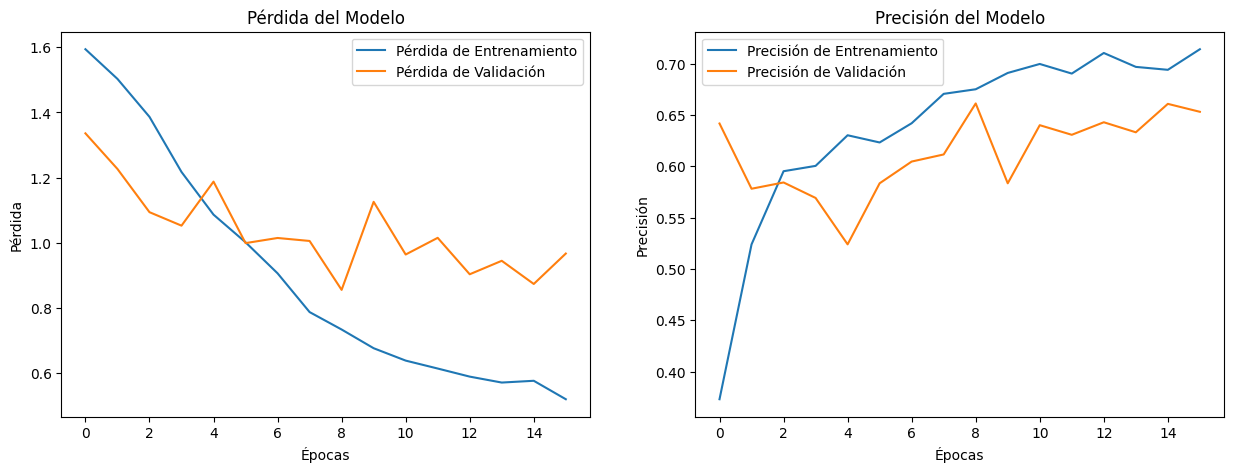

In [147]:
# Gráfica de la historia del entrenamiento

def plot_history(history):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Graficar la pérdida
    ax1.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    ax1.plot(history.history['val_loss'], label='Pérdida de Validación')
    ax1.set_title('Pérdida del Modelo')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    
    # Graficar la precisión
    ax2.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
    ax2.plot(history.history['val_accuracy'], label='Precisión de Validación')
    ax2.set_title('Precisión del Modelo')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Precisión')
    ax2.legend()
    
    plt.show()

plot_history(history)

Las siguientes gráficas muestran la evolución de la pérdida y la precisión del modelo a lo largo de las épocas, tanto en el conjunto de entrenamiento como en el de validación. En ellas se puede ver:

Gráfica 1: Pérdida del Modelo
- La pérdida de entrenamiento muestra una disminución constante, lo que indica que el modelo está aprendiendo y ajustando sus pesos correctamente.
- La pérdida de validación también disminuye en las primeras épocas, pero presenta fluctuaciones a partir de la época 4, lo cual es un signo de sobreajuste, ya que incluso aumenta en las épocas 4, 9, 11, 13, 15, el aumento no es drástico pero provoca que no disminuya con el paso de las épocas.

Gráfica 2: Precisión del Modelo
- La precisión de entrenamiento aumenta de forma progresiva, alcanzando valores cercanos al 0.70.
- La precisión de validación es más irregular, pero sigue una tendencia creciente , estabilizándose alrededor del 0.65.
- La diferencia entre ambas curvas al final del entrenamiento indica un leve sobreajuste, aunque el uso de ```EarlyStopping``` ayuda a controlarlo.

Como conclusión:
- El modelo en entrenamiento mejora tanto en pérdida como en precisión, pero en el momento de validar, la trayectoria no es la misma, ni los valores que se alcanzan lo que significa que se está produciendo overfitting con el paso de las épocas. Por ello se hizo uso de ```EarlyStopping``` y se paró en la época 9.

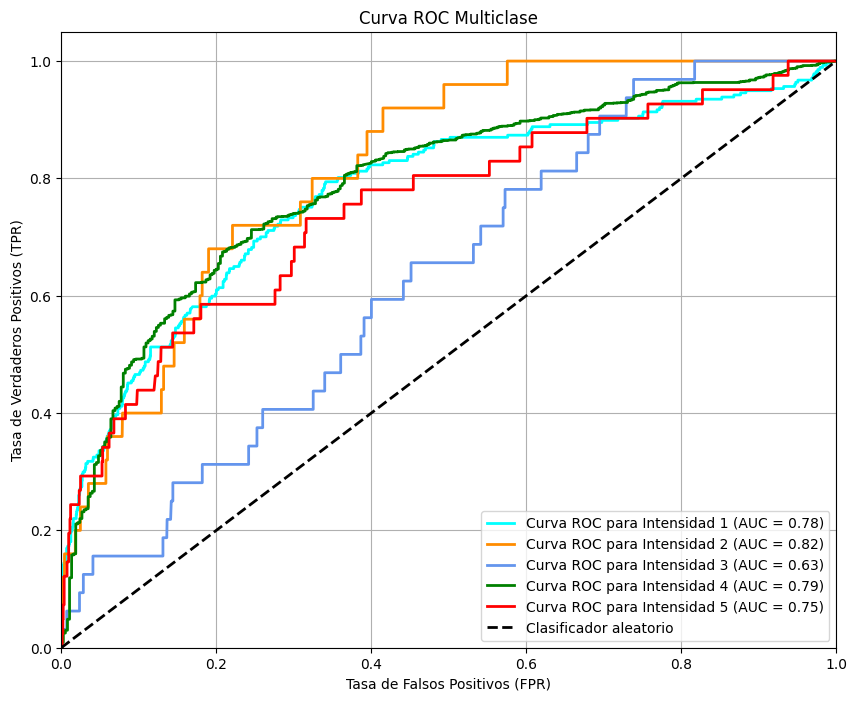

In [148]:
# Gráfica de la curva ROC para el modelo multiclase

def plot_roc_curve_multiclass(y_true, y_pred_probs, class_names):
    # Binarizar etiquetas verdaderas
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    n_classes = y_true_bin.shape[1]

    # Almacenar tasas y AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calcular curva ROC y AUC para cada clase
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Colores de cada curva
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])

    plt.figure(figsize=(10, 8))

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Curva ROC para {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Clasificador aleatorio')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC Multiclase')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc_curve_multiclass(y_true, y_pred_probs, class_names)

La curva ROC permite evaluar el rendimiento del modelo clasificando cada clase frente a las demás. En el contexto multiclase, se genera una curva ROC para cada clase individualmente. En el eje X se representa la tasa de falsos positivos (FPR) y en el eje Y la tasa de verdaderos positivos (TPR), cuanto más arriba y a la izquierda se encuentre una curva, mejor rendimiento tiene el modelo en esa clase. La línea negra discontinua representa un clasificador aleatorio (AUC = 0.5). Toda curva por encima de esta indica que el modelo está aprendiendo. AUC es el área deabajo de la curva ROC.

Revisando los resultados por cada clase:

- Intensidad 1: obtiene un AUC de 0.78, no es mal rendimiento, el modelo distingue razonablemente bien esta clase.
- Intensidad 2: obtiene un AUC de 0.82, a pesar del bajo recall observado antes, el AUC indica que el modelo sí aprende a discriminar esta clase.
- Intensidad 3: obtiene un AUC de 0.63, es bajo, coherente con los resultados débiles del informe de clasificación.
- Intensidad 4: obtiene un AUC de 0.79, alta capacidad para distinguir esta clase, lo que confirma su dominio en las predicciones.
- Intensidad 5: obtiene un AUC de 0.75, es aceptable; aunque su F1-score fue bajo, el modelo sí reconoce ciertos patrones de esta clase.

Como conclusión:

- Las curvas ROC muestran que el modelo tiene capacidad de discriminación para todas las clases, especialmente para la 2, 1 y 4.
- Aunque algunas clases tienen bajo rendimiento general (por ejemplo, Intensidad 3), el valor AUC sugiere que con mejores umbrales o mayor representación de datos, el modelo podría mejorar significativamente.


## 5. Conclusiones

En base a los resultados obtenidos, se concluye que la implementación de una RNN con LSTM bidireccional, junto con el uso de `class_weight` durante el entrenamiento, fue adecuada para enfrentar el marcado desbalance de clases en el conjunto de datos. 

Aún así, la falta de ejemplos en algunas categorías limitó el rendimiento global. Por ejemplo, la intensidad 2 cuenta únicamente con 25 muestras y la intensidad 3 con 32. Con tan pocos ejemplos, ningún modelo por complejo que sea, puede aprender a reconocer patrones representativos. El recall del 0.16 en la intensidad 3 evidencia que el modelo casi nunca identifica correctamente esos pocos casos. Aunque el ajuste de pesos durante el entrenamiento obliga al modelo a esforzarse más en las clases minoritarias, no puede generar información que no existe. Esto suele derivar en un aumento del recall a costa de una precisión extremadamente baja, tal como sucede en la intensidad 5 (acierta el 32% de las veces que debería, pero solo el 9% de las predicciones de esta clase son correctas). En este sentido, aunque la ponderación de clases mejora la sensibilidad hacia las categorías menos frecuentes, no basta para compensar completamente la falta de datos.

Por otra parte, este modelo LSTM profundo está aprendiendo el lenguaje español desde cero con apenas 12.000 mensajes de entrenamiento. No posee ningún conocimiento previo de gramática, semántica o contexto cultural, todos ellos elementos críticos para capturar matices de lenguaje de odio. En consecuencia, el modelo muestra un desempeño razonable al diferenciar la clase mayoritaria (4) y la clase 1, donde existe una representación suficiente de datos, pero resulta prácticamente incapaz de distinguir las clases 2, 3 y 5 con fiabilidad.

En términos de efectividad, este modelo supera con creces una línea base ingenua (que predijera siempre la clase mayoritaria), demostrando que es capaz de diferenciar de manera fiable los mensajes con intensidad 1 y 4. Sin embargo, la identificación de intensidades 2, 3 y 5 sigue siendo limitada y requeriría posibles líneas de trabajo futuras como: la incorporación de técnicas de aumento de datos para texto para tener un mayor número de ejemplos, el uso de modelos preentrenados Transformer con conocimiento previo del idioma, o experimentar con diferentes hiperparámetros.

Como conclusiones finales podemos destacar las siguiente:

- El modelo demuestra una capacidad real de discriminación para todas las clases, especialmente en las intensiades 1, 2 y 4, con valores de AUC cercanos o superiores a 0.78

- Para clases con rendimiento general más bajo (como la Intensidad 3), el AUC de 0.63 sugiere que el modelo aún capta cierta estructura, aunque insuficiente para lograr una buena clasificación con el umbral actual.

- En conjunto, los valores de AUC revelan que el modelo no es aleatorio y tiene potencial para mejorar. Una estrategia futura sería ajustar los umbrales de decisión por clase o **balancear el conjunto de datos**, especialmente en clases con menor representación, lo que podría traducirse en mejoras significativas en precisión y recall.